## 203: Exampville Destination Choice

Welcome to Exampville, the best simulated town in this here part of the internet!

Exampville is a demonstration provided with Larch that walks through some of the 
data and tools that a transportation planner might use when building a travel model. 

In [1]:
import larch, numpy, pandas, os
from larch import P, X

In [2]:
larch.__version__

'5.4.0'

In this example notebook, we will walk through the estimation of a tour 
destination choice model.  First, let's load the data files from
our example.

In [3]:
hh, pp, tour, skims, emp = larch.example(200, ['hh', 'pp', 'tour', 'skims', 'emp'])

For this destination choice model, we'll want to use the mode choice
logsums we calculated previously from the mode choice estimation,
but we'll use these values as fixed input data instead of a modeled value.  
We can load these logsums from the file in which they were saved. 
For this example, we can indentify that file using the `larch.example` 
function, which will automatically rebuild the file if it doesn't exists.
In typical applications, a user would generally just give the filename 
as a string and ensure manually that the file exists before loading it.

In [4]:
logsums_file = larch.example(202, output_file='/tmp/logsums.pkl.gz')
logsums = pandas.read_pickle(logsums_file)

### Preprocessing

We'll replicate the pre-processing used in the mode choice estimation,
to merge the household and person characteristics into the tours data,
add the index values for the home TAZ's, filter to include only 
work tours, and merge with the level of service skims. (If this 
pre-processing was computationally expensive, it would probably have
been better to save the results to disk and reload them as needed,
but for this model these commands will run almost instantaneously.)

In [5]:
raw = tour.merge(hh, on='HHID').merge(pp, on=('HHID', 'PERSONID'))
raw["HOMETAZi"] = raw["HOMETAZ"] - 1
raw["DTAZi"] = raw["DTAZ"] - 1
raw = raw[raw.TOURPURP == 1]
raw.index.name = 'CASE_ID'

The alternatives in
the destinations model are much more regular than in the mode choice 
model, as every observation will have a similar set of alternatives
and the utility function for each of those alternatives will share a 
common functional form.  We'll leverage this by using `idca` format 
to make data management simpler.  

First, we'll assemble some individual variables that we'll want to use.
We can build an array to represent the distance to each destination based
on the `"AUTO_DIST"` matrix in the `skims` OMX file. 

In [6]:
distance = pandas.DataFrame(
    data=skims.AUTO_DIST[:][raw["HOMETAZi"], :],
    index=raw.index,
    columns=skims.TAZ_ID,
) 

This command pulls the relevant row, identified by the `"HOMETAZi"` column
in the `raw` data, into each row of a new DataFrame, which has a row for each
case and a column for each alterative. 

Note that the `[:]` 
inserted into the `data` argument is used to instruct the `pytables` module
to load the entire matrix into memory, and then `numpy` indexing is used to 
actually select out the rows needed.  This is a technical limitation of
the `pytables` module and could theoretically be a very computationally 
expensive step if the skims matrix is huge relative to the number of rows in
the `raw` DataFrame. However, in practice a single matrix from the skims file
is generally not that large compared to the number of observations, and this
step can be processed quite efficiently.

The logsums we previously loaded is in the same format as the `distance`, 
with a row for each case and a column for each alterative. To use the `idca` 
format, we'll reshape these data, so each is a single column 
(i.e., a `pandas.Series`), with a two-level `MultiIndex` giving case and 
alternative respectively, and then assemble these columns into a single 
DataFrame.  We can do the reshaping using the `stack` method, and we will
make sure the resulting Series has an appropriate name using `rename`, before 
we combine them together using `pandas.concat`:

In [7]:
ca = pandas.concat([
    distance.stack().rename("distance"),
    logsums.stack().rename("logsum"), 
], axis=1)

In [8]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 302560 entries, (0, 1) to (20736, 40)
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   distance  302560 non-null  float64
 1   logsum    302560 non-null  float64
dtypes: float64(2)
memory usage: 5.5 MB


For our destination choice model, we'll also want to use employment data.
This data, as included in our example, has unique 
values only by alternative and not by caseid, so there are only
40 unique rows.
(This kind of structure is common for destination choice models.)

In [9]:
emp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1 to 40
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   NONRETAIL_EMP  40 non-null     int64
 1   RETAIL_EMP     40 non-null     int64
 2   TOTAL_EMP      40 non-null     int64
dtypes: int64(3)
memory usage: 1.2 KB


To make this work with the computational 
arrays required for Larch, we'll need to join this to the other 
`idca` data.  Doing so is simple, because the index of the `emp` DataFrame
is the same as the alternative id level of the `ca` MultiIndex.  You can see
the names of the levels on the MultiIndex like this:

In [10]:
ca.index.names

FrozenList(['CASE_ID', 'TAZ_ID'])

Knowing the name on the alternatives portion of the `idca` data lets us 
join the employment data like this:

In [11]:
ca = ca.join(emp, on='TAZ_ID')

Then we bundle the raw data along with this newly organized `idca` data,
into the `larch.DataFrames` structure, which is used for estimation.
This structure also identifies a vector of the alterative codes 
and optionally, names and choice identifiers.
This structure can be attached to a model as its `dataservice`.

In [12]:
dfs = larch.DataFrames(
    co=raw,
    ca=ca,
    alt_codes=skims.TAZ_ID, 
    alt_names=['TAZ{i}' for i in skims.TAZ_ID],
    ch_name='DTAZ',
    av=1,
)

In [13]:
dfs.info(1)

larch.DataFrames:  (not computation-ready)
  n_cases: 7564
  n_alts: 40
  data_ca:
    - distance      (302560 non-null float64)
    - logsum        (302560 non-null float64)
    - NONRETAIL_EMP (302560 non-null int64)
    - RETAIL_EMP    (302560 non-null int64)
    - TOTAL_EMP     (302560 non-null int64)
  data_co:
    - TOURID        (7564 non-null int64)
    - HHID          (7564 non-null int64)
    - PERSONID      (7564 non-null int64)
    - DTAZ          (7564 non-null int64)
    - TOURMODE      (7564 non-null int64)
    - TOURPURP      (7564 non-null int64)
    - N_STOPS       (7564 non-null int64)
    - N_TRIPS_x     (7564 non-null int64)
    - N_TRIPS_HBW_x (7564 non-null int64)
    - N_TRIPS_HBO_x (7564 non-null int64)
    - N_TRIPS_NHB_x (7564 non-null int64)
    - X             (7564 non-null float64)
    - Y             (7564 non-null float64)
    - INCOME        (7564 non-null float64)
    - N_VEHICLES    (7564 non-null int64)
    - HHSIZE        (7564 non-null int64)
    

### Model Definition

In [14]:
m = larch.Model(dataservice=dfs)
m.title = "Exampville Work Tour Destination Choice v1"

In [15]:
m.quantity_ca = (
        + P.EmpRetail_HighInc * X('RETAIL_EMP * (INCOME>50000)')
        + P.EmpNonRetail_HighInc * X('NONRETAIL_EMP') * X("INCOME>50000")
        + P.EmpRetail_LowInc * X('RETAIL_EMP') * X("INCOME<=50000")
        + P.EmpNonRetail_LowInc * X('NONRETAIL_EMP') * X("INCOME<=50000")
)

m.quantity_scale = P.Theta


In [16]:
m.utility_ca = (
    + P.logsum * X.logsum
    + P.distance * X.distance
)

In [17]:
m.lock_values(
    EmpRetail_HighInc=0,
    EmpRetail_LowInc=0,
)

### Model Estimation

In [18]:
m.load_data()

req_data does not request {choice_ca,choice_co,choice_co_code} but choice is set and being provided
req_data does not request avail_ca or avail_co but it is set and being provided


In [19]:
m.loglike()

-28238.3368809997

In [20]:
m.maximize_loglike()

,value,initvalue,nullvalue,minimum,maximum,holdfast,note,best
EmpNonRetail_HighInc,1.363793,0.0,0.0,-inf,inf,0,,1.363793
EmpNonRetail_LowInc,-0.881379,0.0,0.0,-inf,inf,0,,-0.881379
EmpRetail_HighInc,0.000000,0.0,0.0,0.000,0.0,1,,0.000000
EmpRetail_LowInc,0.000000,0.0,0.0,0.000,0.0,1,,0.000000
Theta,0.749374,1.0,1.0,0.001,1.0,0,,0.749374
distance,-0.041820,0.0,0.0,-inf,inf,0,,-0.041820
logsum,1.020821,0.0,0.0,-inf,inf,0,,1.020821


┣                x: EmpNonRetail_HighInc    1.363793
┃                   EmpNonRetail_LowInc    -0.881379
┃                   EmpRetail_HighInc       0.000000
┃                   EmpRetail_LowInc        0.000000
┃                   Theta                   0.749374
┃                   distance               -0.041820
┃                   logsum                  1.020821
┃                   dtype: float64
┣          loglike: -25157.726761693477
┣        d_loglike: EmpNonRetail_HighInc    0.003254
┃                   EmpNonRetail_LowInc     0.003049
┃                   EmpRetail_HighInc       0.000000
┃                   EmpRetail_LowInc        0.000000
┃                   Theta                   0.006297
┃                   distance               -0.014778
┃                   logsum                 -0.000878
┃                   dtype: float64
┣              nit: 13
┣             nfev: 32
┣             njev: 13
┣           status: 0
┣          message: 'Optimization terminated successfully.'
┣          success: True
┣     elapsed_time: datetime.timedelta(seconds=2, microseconds=601596)
┣           method: 'slsqp'
┣          n_cases: 7564
┣ iteration_number: 13
┣          logloss: 3.3259818563846477

In [21]:
m.calculate_parameter_covariance()

### Model Visualization

For destination choice and similar type models, it might be beneficial to
review the observed and modeled choices, and the relative distribution of
these choices across different factors.  For example, we would probably want
to see the distribution of travel distance.  The `Model` object includes
a built-in method to create this kind of visualization.

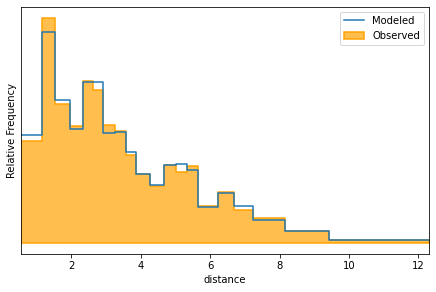

In [22]:
m.distribution_on_idca_variable('distance')

The `distribution_on_idca_variable` has a variety of options,
for example to control the number and range of the histogram bins:

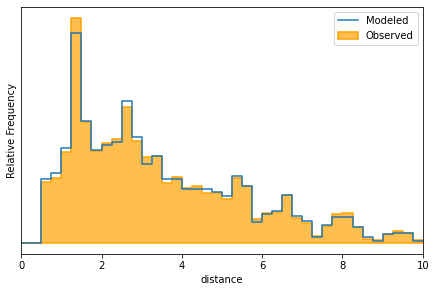

In [23]:
m.distribution_on_idca_variable('distance', bins=40, range=(0,10))

Alternatively, the histogram style can be swapped out for a smoothed kernel density
function:

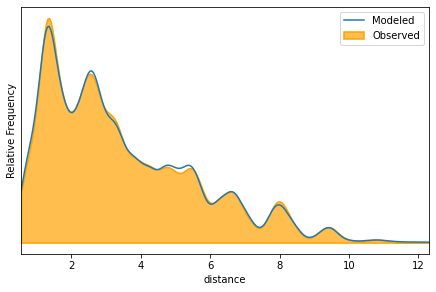

In [24]:
m.distribution_on_idca_variable(
    'distance',
    style='kde',
)

Subsets of the observations can be pulled out, to observe the 
distribution conditional on other `idco` factors, like income.

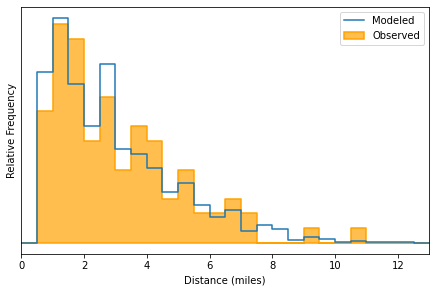

In [25]:
m.distribution_on_idca_variable(
    'distance',
    xlabel="Distance (miles)",
    bins=26,
    subselector='INCOME<10000',
    range=(0,13),
    header='Destination Distance, Very Low Income (<$10k) Households',
)

### Save and Report Model

In [26]:
report = larch.Reporter(title=m.title)

In [27]:
report << '# Parameter Summary' << m.parameter_summary()

,Value,Std Err,t Stat,Signif,Null Value,Constrained
EmpNonRetail_HighInc,1.36,0.256,5.32,***,0.00,
EmpNonRetail_LowInc,-0.881,0.0791,-11.14,***,0.00,
EmpRetail_HighInc,0.00,NA,NA,,0.00,fixed value
EmpRetail_LowInc,0.00,NA,NA,,0.00,fixed value
Theta,0.749,0.0152,-16.45,***,1.00,
distance,-0.0418,0.0107,-3.90,***,0.00,
logsum,1.02,0.0317,32.16,***,0.00,


In [28]:
report << "# Estimation Statistics" << m.estimation_statistics()

<xmle.Elem 'div' with 5 children>

In [29]:
report << "# Utility Functions" << m.utility_functions()

+ P.logsum * X.logsum + P.distance * X.distance + P.Theta * log( + exp(P.EmpRetail_HighInc) * X('RETAIL_EMP * (INCOME>50000)') + exp(P.EmpNonRetail_HighInc) * X('NONRETAIL_EMP*(INCOME>50000)') + exp(P.EmpRetail_LowInc) * X('RETAIL_EMP*(INCOME<=50000)') + exp(P.EmpNonRetail_LowInc) * X('NONRETAIL_EMP*(INCOME<=50000)'))


The figures shown above can also be inserted directly into reports.

In [30]:
figure = m.distribution_on_idca_variable(
    'distance', 
    xlabel="Distance (miles)",
    style='kde',
    header='Destination Distance',
)
report << "# Visualization"
report << figure

<xmle.Elem 'div' with 9 children>

In [31]:
report.save(
    '/tmp/exampville_dest_choice.html',
    overwrite=True,
    metadata=m,
)

'/tmp/exampville_dest_choice.html'